In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

from ml_utils import *

In [3]:
torch.backends.cudnn.benchmark=True

In [4]:
PATH = Path('data/pascal/2007')
IMGS = 'VOCdevkit/VOC2007/JPEGImages'

## Prepare data

In [5]:
with open(PATH/'PASCAL_VOC/pascal_train2007.json') as i:
    d = json.load(i)

print(d.keys())
    
categories = pd.DataFrame(d['categories'])
annotations = pd.DataFrame(d['annotations'])
images = pd.DataFrame(d['images'])

dict_keys(['images', 'type', 'annotations', 'categories'])


In [6]:
categories.head()

,id,name,supercategory
0,1,aeroplane,none
1,2,bicycle,none
2,3,bird,none
3,4,boat,none
4,5,bottle,none


In [7]:
annotations.head()

,area,bbox,category_id,id,ignore,image_id,iscrowd,segmentation
0,34104,"[155, 96, 196, 174]",7,1,0,12,0,"[[155, 96, 155, 270, 351, 270, 351, 96]]"
1,13110,"[184, 61, 95, 138]",15,2,0,17,0,"[[184, 61, 184, 199, 279, 199, 279, 61]]"
2,81326,"[89, 77, 314, 259]",13,3,0,17,0,"[[89, 77, 89, 336, 403, 336, 403, 77]]"
3,64227,"[8, 229, 237, 271]",2,4,0,23,0,"[[8, 229, 8, 500, 245, 500, 245, 229]]"
4,29505,"[229, 219, 105, 281]",2,5,0,23,0,"[[229, 219, 229, 500, 334, 500, 334, 219]]"


In [8]:
images.head()

,file_name,height,id,width
0,000012.jpg,333,12,500
1,000017.jpg,364,17,480
2,000023.jpg,500,23,334
3,000026.jpg,333,26,500
4,000032.jpg,281,32,500


In [19]:
df_img = images.merge(annotations, left_on='id', right_on='image_id') \
          .merge(categories, how='left', left_on='category_id', right_on='id')
df_img.rename(columns={'name': 'category'}, inplace=True)
df_img.drop(np.where(df_img.ignore == 1)[0], inplace=True)

In [20]:
df_img['bbox_fastai_str'] = df_img.bbox.apply(bb_hw_to_fastai).apply(lambda lst: ' '.join(str(i) for i in lst))

In [21]:
df_multi = df_img.pivot_table(values='category', index='file_name', aggfunc=lambda s: ' '.join(set(s)))
df_multi.reset_index(inplace=True)
df_multi.to_csv(PATH/'multiple_cats_per_image.csv', index=False)
df_multi.head()

,file_name,category
0,000012.jpg,car
1,000017.jpg,horse person
2,000023.jpg,person bicycle
3,000026.jpg,car
4,000032.jpg,aeroplane person


### Data for ObjectDetectionData object

In [22]:
df_class = df_img.pivot_table(values='category', index='file_name', aggfunc=lambda s: ' '.join(s))
df_class.reset_index(inplace=True)

In [23]:
df_class.head()

,file_name,category
0,000012.jpg,car
1,000017.jpg,person horse
2,000023.jpg,bicycle bicycle person person person
3,000026.jpg,car
4,000032.jpg,aeroplane aeroplane person person


In [24]:
df_bb = df_img.pivot_table(values='bbox_fastai_str', index='file_name', aggfunc=lambda s: ' '.join(s))
df_bb.reset_index(inplace=True)

In [25]:
df_bb.head()

,file_name,bbox_fastai_str
0,000012.jpg,96 155 269 350
1,000017.jpg,61 184 198 278 77 89 335 402
2,000023.jpg,229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3,000026.jpg,124 89 211 336
4,000032.jpg,77 103 182 374 87 132 122 196 179 194 228 212 ...


In [26]:
df_class['bbox_fastai_str'] = df_bb['bbox_fastai_str']

In [27]:
df_class.head()

,file_name,category,bbox_fastai_str
0,000012.jpg,car,96 155 269 350
1,000017.jpg,person horse,61 184 198 278 77 89 335 402
2,000023.jpg,bicycle bicycle person person person,229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3,000026.jpg,car,124 89 211 336
4,000032.jpg,aeroplane aeroplane person person,77 103 182 374 87 132 122 196 179 194 228 212 ...


In [28]:
df_class.to_csv(PATH/'classes_and_bbs.csv', index=False)

## Multiple classes per image

In [9]:
f_model=resnet34
sz=224
bs=64

In [10]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, IMGS, PATH/'multiple_cats_per_image.csv', tfms=tfms)
learn = ConvLearner.pretrained(f_model, md, opt_fn=optim.Adam)

In [15]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      1.071272   6.997115   0.7462    



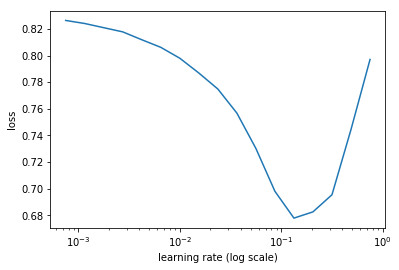

In [16]:
learn.sched.plot()

In [17]:
lr = 2e-2
metrics = [lambda p, t: accuracy_multi(p, t, 0.5), recall, precision]

learn.fit(lr, 1, cycle_len=3, use_clr=(32,5), metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   recall     precision  
    0      0.334139   0.143663   0.9555     0.790859   0.695381  
    1      0.181051   0.089842   0.9681     0.742815   0.842548  
    2      0.124739   0.087299   0.97       0.732494   0.874438  



[0.08729910743236542,
 0.969999997138977,
 0.7324937242081829,
 0.8744378158482347]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████▏ | 26/32 [00:03<00:00,  6.70it/s, loss=0.422] 


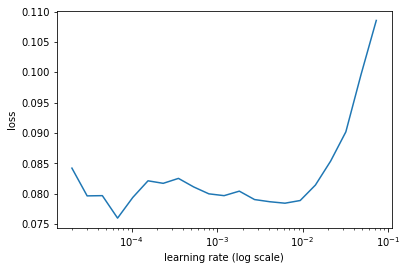

In [18]:
lrs = np.array([lr/100, lr/10, lr])

learn.freeze_to(-2)

learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [19]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,5), metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   recall     precision  
    0      0.080684   0.092903   0.969      0.727093   0.865158  
    1      0.060807   0.089338   0.9708     0.727274   0.889695  
    2      0.044344   0.090063   0.9725     0.734631   0.905859  
    3      0.031938   0.090419   0.9723     0.7305     0.906351  
    4      0.023107   0.089805   0.9722     0.743527   0.893301  



[0.08980509060621261,
 0.9721999917030334,
 0.7435272581201112,
 0.8933011508218519]

In [32]:
# learn.save('mclas')

In [15]:
learn.load('mclas')

In [20]:
y_hat = learn.predict() > 0.5
x,y = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


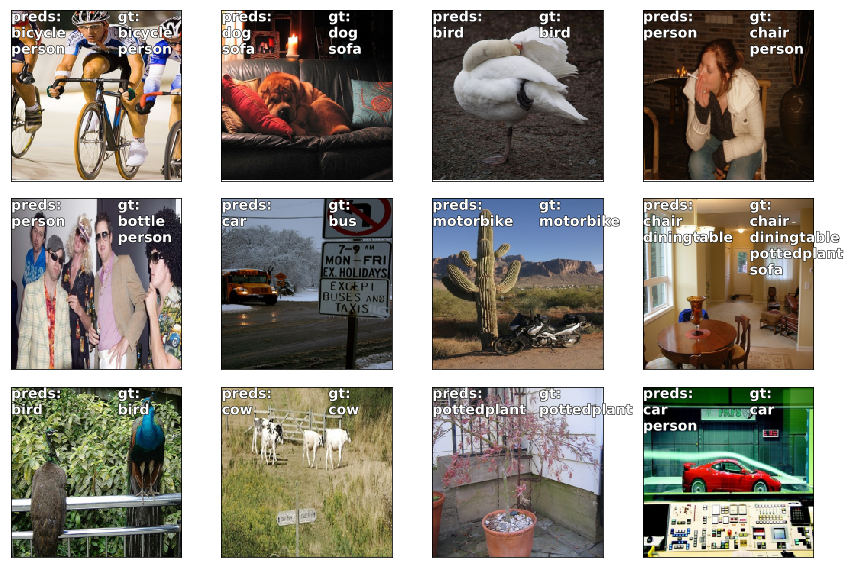

In [21]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    im = md.val_ds.denorm(x)[i]
    predicted_cats = np.nonzero(y_hat[i])[0]
    gt_cats = np.nonzero(to_np(y[i]))[0]
    
    labels = '\n'.join(md.classes[i] for i in predicted_cats)
    gt_labels = '\n'.join(md.classes[i] for i in gt_cats)
    
    ax = show_im(im, ax=ax)
    draw_text(ax, (0,0), 'preds:\n' + labels)
    draw_text(ax, (140,0), 'gt:\n' + gt_labels)
plt.tight_layout()

## Single anchor box per cell

In [5]:
f_model=resnet34
sz=224
bs=64

In [6]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ObjectDetectionData.from_csv(PATH, IMGS, PATH/'classes_and_bbs.csv', tfms=tfms, val_ratio=0.2)

In [7]:
batch = next(iter(md.trn_dl))

In [8]:
batch[0][0].shape, batch[1][0].shape, batch[1][1].shape

(torch.Size([3, 224, 224]), torch.Size([64, 18]), torch.Size([64, 72]))

In [9]:
batch[1][0][:2]



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    4     4    19    14    14     4     4     4     4     4     4     4     4

Columns 13 to 17 
    0     0     0    12    14
    4     4     4     4    17
[torch.cuda.LongTensor of size 2x18 (GPU 0)]

In [10]:
batch[1][1][:2]



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
   89   143   123   148   172    85   220    93    60     2   120    37    48

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    2   220   102    78   119   220   209     0    55    13    56     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0    48    14    48     0    45    13    45     0    40    13

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0
   41     0    37    13    37     0    34    13    34     0     0     0     0

Columns 52 to 64 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0    15    14    16     0    19    14    20     0    26    13    27     0

Columns 65 to 71 
   14   217   213     2     3   185    68
   23    13    25    90    94   220   223
[torch.cuda.FloatTenso

In [7]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [57]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.4, show_grid=False):
    bb = [bb_fastai_to_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_im(im, ax=ax, show_grid=show_grid)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(md.classes) else md.classes[int(c)])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [340]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [342]:
bs

64

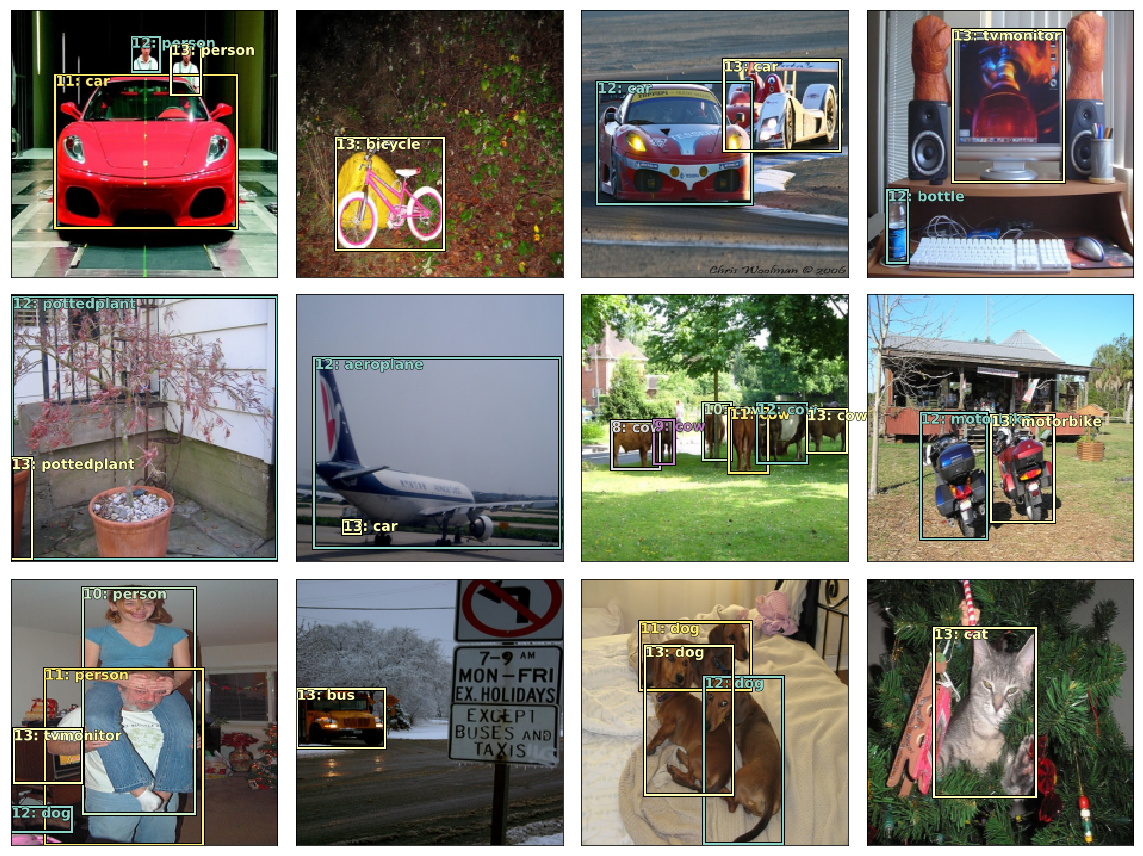

In [360]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
picked_ids = set()
for i,ax in enumerate(axes.flat):
    ri = np.random.randint(bs)
    while ri in picked_ids: ri = np.random.randint(bs)
    picked_ids.add(ri)
    show_ground_truth(ax, x[ri], y[1][ri], y[0][ri])
plt.tight_layout()

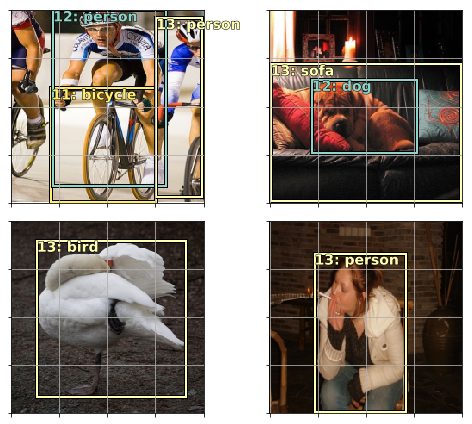

In [361]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[1][i], y[0][i], show_grid=True)
plt.tight_layout()

####  Building the model

In [9]:
anc_grid = 4 # anchor grid size
k = 1 # number of anchor boxes per grid cell

anc_offset = 1/(anc_grid * 2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
# added the below line to make it work with k != 1 but not sure if this will work
# (whether anchors of repeated shape will make sense with the cost function)
anc_sizes = np.repeat(anc_sizes, k, 0)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [10]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [11]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)
grid_sizes

Variable containing:
 0.2500
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

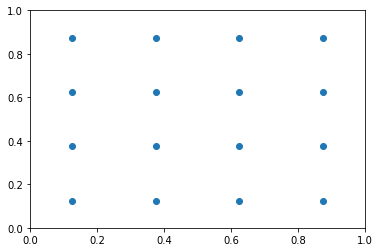

In [12]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [13]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [14]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [15]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

In [16]:
def flatten_conv(x,k):
    bs,nf,gy,gx = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [17]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(md.classes)+1)*k, 3, padding=1) # (20+1)x4x4 with k == 1
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1) #  4x4x4 with k == 1, those will be predicted offsets
        # to centers and widths and heights of the anchor boxes
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [18]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1) # 7x7
        self.sconv1 = StdConv(256,256)

        self.sconv1 = StdConv(256,256) # 4x4
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        return self.out(x)

In [328]:
def ssd_loss(pred,targ):
    lcs,lls = 0.,0.
    for b_c,b_bb,clas,bbox in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas)
        lls += loc_loss
        lcs += clas_loss
    return lls+lcs

In [20]:
def intersect(box_a, box_b):
    """ Intersection of every box_a with every box_b
    With 2 target bounding boxes,
    
    shapes (example):
        box_a: (2, 4)
        box_b: (16, 4)
        box_a[:, None, 2:]: (2, 1, 2)
        box_b[None, :, 2:]: (1, 16, 2)
        
        box_a[:, None, :2]: (2, 1, 2)
        box_b[None, :, :2]: (1, 16, 2)
        
        max_xy: (2, 16, 2)
        min_xy: (2, 16, 2)
        
        inter: (2, 16, 2)
        inter[:, :, 0] * inter[:, :, 1]: (2, 16)
        
    legend:
        max_xy: the lower right hand corner of the resultant intersection
        min_xy: the upper left hand corner
        
        inter[:, :, 0]: intersection heigth
        inter[:, :, 1]: intersection width
        
    """
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): 
    """ Area of boxes
    
    shapes:
        b: (n, 4)
        
    result shape: (n,)
    """
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    """ Calculate the IOU (intersection over union) for two sets of boxes
    
    shapes (example):
        box_a: (3, 4)
        box_b: (16, 4)
        
        inter: (3, 16)
        box_sz(box_a): (3,)
        box_sz(box_b): (16,)
        sum after unsqueezing: (3, 16)
        
        inter / union: (3, 16)
    
    """
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [21]:
def map_to_ground_truth(overlaps):
    """
    Arguments:
        overlaps: a (gt, anchor_count) array with jaccard score between each pair
    
    With 2 target bounding boxes and a 4x4 grid
    
    shapes (example):
        overlaps: (2, 16)
        prior_overlap: (2,)
        prior_idxs: (2,)
        
        gt_overlap: (16,)
        gt_idx: (16,)
        
    legend:
        overlaps: overlap between all gts (target bounding boxes) and anchors
        
        prior_overlap: gt overlap with anchor boxes    
        gt_overlap: anchor boxes overlap with gt
        gt_idx: idx of gt (bounding box) that overlaps most with the anchor box
        
    returns:
        An area of max overlap with any gt for each anchor box and the idx of the gt
        of maximium overlap.

    """
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i # this seems arbitrary - if there is an object with a 
        # smaller area in an anchor, and one with bigger, but for the smaller its the only anchor box it
        # appears in, we want to predict the smaller one - sounds like a tough thing to ask our NN for,
        # at the same time seems like this is the only way to attemtp to predict for every gt (assuming there
        # exist enough anchor boxes)
    return gt_overlap,gt_idx

In [339]:
def ssd_1_loss(b_c,b_bb,bbox,clas):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors) # these are predicted bounding boxes (anchors modified by offsets)
    overlaps = jaccard(bbox.data, anchor_cnr.data) # overlaps shape: (len(bbox), 16) for k = 1 and anc_grid = 4,
    gt_overlap,gt_idx = map_to_ground_truth(overlaps)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4 # we consider as positive examples such anchor boxes that are either the ones that our gt
    # overlaps most with - regardless of the area of overlap, or ones where the overlap of gt and an anchor box is < 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(md.classes) # this is a neat trick - we don't want to
    # predict the bg class, but we need to somehow mark empty gt boxes
    #
    # Problem is class 0 already means something so that will not work. We could set
    # the gt to None but that might mean we would need to do something tricky at some point
    #
    # To simplify the matters, we set the gt to class len(classes) + 1 to indicate background. This works nicely
    # with one hot encoding that we do later on and allows us to very efficiently (in terms of lines of code and clarity)
    # chop off this information for cost calculation.
    #
    # Objects that overlap most with a single anchor box and where the less overlapping object does not overlap with
    # another anchor > 0.4 will be disregarded (easy to fix via greater number of anchor boxes)
    gt_bbox = bbox[gt_idx] # grabbing the gt bbox that overlaps with an anchor box the most
        # its okay if len(gt_idx) > len(bbox) as long as all gt_idx < len(bbox) - 1
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean() # only the activations for anchor boxes with obj count!
    clas_loss = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

In [23]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:, :-1].contiguous())
        x = pred[:, :-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(20)

In [24]:
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

In [26]:
def get_y(bbox,clas):
    """Get only nonzero target bounding boxes and classes"""
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

In [27]:
custom_head = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=custom_head)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

In [28]:
learn.crit = ssd_loss

In [29]:
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      109.391423 34691.744641



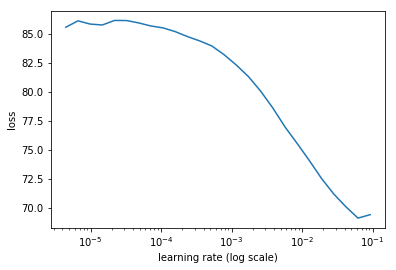

In [114]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [52]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      42.719117  32.906019 
    1      33.607128  28.362409                           
    2      29.485265  27.377349                           
    3      26.603607  26.148101                           
    4      24.430272  25.874025                           



[array([25.87403])]

In [56]:
learn.freeze_to(-2)

In [91]:
for l in learn.model:
    print(type(l).__name__, l.trainable)

Conv2d False
BatchNorm2d False
ReLU False
MaxPool2d False
Sequential False
Sequential False
Sequential True
Sequential True
SSD_Head True


In [92]:
learn.fit(lrs, 1, cycle_len=3, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      27.506117  31.301079 
    1      25.499472  27.919765                           
    2      22.752238  24.960926                           



[array([24.96093])]

In [93]:
# learn.save('single_anchor')

In [222]:
learn.load('single_anchor')

### Visualizing results

In [154]:
x,y = next(iter(md.val_dl))

In [91]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.4, show_grid=False):
    bb = [bb_fastai_to_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_im(im, ax=ax, show_grid=show_grid)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(md.classes) else md.classes[int(c)])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [193]:
def show_torch_ground_truth(im, bbs, clas=None, ax=None, **kwargs):
    im, bbs = to_np(im), to_np(bbs)
    if clas is not None: clas = to_np(clas)
    if ax is None: ax = plt.subplots(figsize=(7,7))[1]
    show_ground_truth(ax, md.trn_ds.denorm(im)[0], bbs, clas, **kwargs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


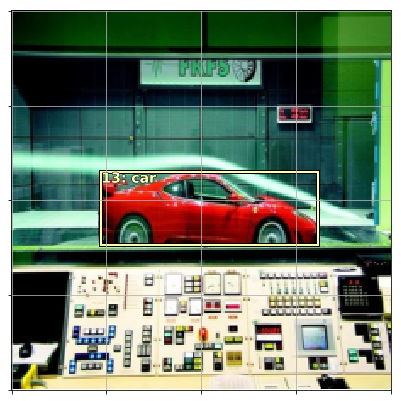

In [236]:
idx = 11
show_torch_ground_truth(x[idx], y[1][idx], y[0][idx], show_grid=True)

In [284]:
def show_torch_predictions(im, bbs, clas=None, ax=None, show_bg=True, **kwargs):
    im, bbs = to_np(im), to_np(actn_to_bb(b_bb[idx], anchors) * sz)
    if clas is not None: clas = to_np(b_c[idx].max(1)[1])
    if ax is None: ax = plt.subplots(figsize=(7,7))[1]
    if not show_bg:
        non_bg_idx = clas != 20
        bbs, clas = bbs[non_bg_idx], clas[non_bg_idx]
    show_ground_truth(ax, md.trn_ds.denorm(im)[0], bbs, clas, **kwargs)

In [238]:
b_c, b_bb = learn.model(V(x))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


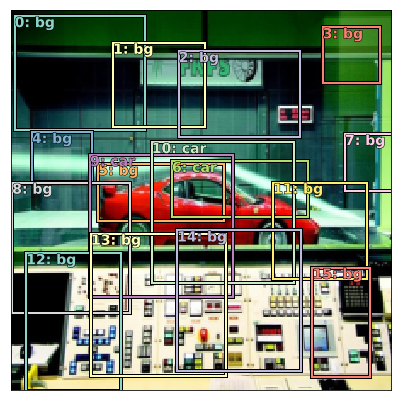

In [287]:
show_torch_predictions(x[idx], b_bb[idx], b_c[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


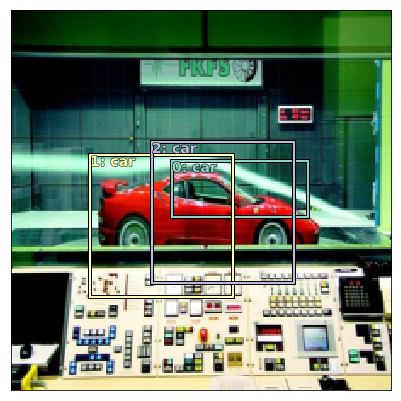

In [286]:
show_torch_predictions(x[idx], b_bb[idx], b_c[idx], show_bg=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


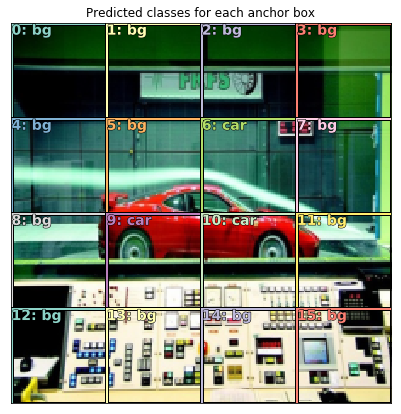

In [243]:
fig, ax = plt.subplots(figsize=(7, 7))
show_ground_truth(ax, md.trn_ds.denorm(x)[idx], to_np(anchor_cnr * sz), to_np(b_c[idx].max(1)[1]))
plt.title('Predicted classes for each anchor box');